In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import inspect
import warnings
warnings.filterwarnings('ignore')


In [149]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


In [150]:


class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        
        
        self.porcentaje_nulos_permitido=0.6

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")





    def plot_normailidad(self):

        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        aux_DF=self.cuanti
        self.df_inputado=self.df
        for i in aux_df:
            nulos=aux_DF[i].isna().sum()
            total=len(aux_DF[i])
            porcentaje=nulos/total
            if ((nulos>0) and (porcentaje<self.porcentaje_nulos_permitido)):
                percen=aux_DF[i].quantile([0.2,0.8]).to_list()
                self.df_inputado[i]=aux_DF[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    





    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        
        

    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

            
        


# CREACIÓN DE LA CLASE

In [151]:
ejemplo=DF_exploracion(df_prueba)


In [152]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [153]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 995 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.005 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 14 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 19 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_F 
|   - Tipo de dato: float64 
|   - Valores repetidos: 619 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.007

## Creación de variables dummys a traves de dicotómicas

In [154]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             1           0       0       1          0          1
1             0           1       1       0          0          1
2             1           0       0       1          1          0
3             1           0       0       1          1          0
4             1           0       1       0          1          0
..          ...         ...     ...     ...        ...        ...
995           0           1       1       0          1          0
996           1           0       1       0          0          1
997           1           0       1       0          1          0
998           0           1       1       0          1          0
999           0           1       0       1          1          0

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [155]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,n,m,1,1.083598,1.697997,2,9,NaN,NaN,Grupo 5,Grupo 1,1,0,0,1,0,1
1,s,h,1,0.660657,-1.774290,6,7,470.0,NaN,Grupo 1,Grupo 3,0,1,1,0,0,1
2,n,m,0,-0.416393,-0.420297,1,6,NaN,NaN,Grupo 5,Grupo 3,1,0,0,1,1,0
3,n,m,0,-1.101476,-0.117598,4,8,NaN,NaN,Grupo 4,Grupo 1,1,0,0,1,1,0
4,n,h,0,-0.300598,0.439750,2,10,479.0,NaN,Grupo 1,Grupo 2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,s,h,0,0.736198,-0.326015,4,7,35.0,942.0,Grupo 5,Grupo 2,0,1,1,0,1,0
996,n,h,1,-0.053348,-0.981339,4,10,666.0,479.0,Grupo 4,Grupo 2,1,0,1,0,0,1
997,n,h,0,-0.003718,-1.584595,0,6,731.0,9.0,Grupo 0,Grupo 2,1,0,1,0,1,0
998,s,h,0,0.067298,-0.584627,2,10,553.0,288.0,Grupo 4,Grupo 3,0,1,1,0,1,0


## Revisión de variables agrupadas automaticamente

In [156]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_F', 'Datos_G']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [157]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
           Datos_D     Datos_E  Datos_Poisson_1  Datos_Poisson_3     Datos_F  \
count  1000.000000  995.000000      1000.000000      1000.000000  993.000000   
mean      0.022662    0.028171         3.896000         9.983000  498.839879   
std       1.025309    0.994048         2.005294         3.204213  279.624200   
min      -3.855091   -3.809218         0.000000         2.000000    1.000000   
25%      -0.626656   -0.637291         2.000000         8.000000  263.000000   
50%       0.032686    0.003864         4.000000        10.000000  487.000000   
75%       0.667834    0.693476         5.000000        12.000000  738.000000   
max       3.333534    3.454546        13.000000        21.000000  999.000000   

          Datos_G  
count  989.000000  
mean   490.494439  
std    282.152149  
min      0.000000  
25%    254.000000  
50%    483.000000  
75%    724.000000  
max   

In [158]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_NO_ES ....................
s    0.511
n    0.489
Name: ES_NO_ES, dtype: float64


...........Frecuencia variable sexo ....................
h    0.504
m    0.496
Name: sexo, dtype: float64


...........Frecuencia variable Datos_C ....................
1    0.545
0    0.455
Name: Datos_C, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_cate_A ....................
Grupo 2    0.187
Grupo 4    0.180
Grupo 5    0.171
Grupo 1    0.155
Grupo 0    0.155
Grupo 3    0.152
Name: Datos_cate_A, dtype: float64


...........Frecuencia variable Datos_cate_B ....................
Grupo 1    0.270
Grupo 3    0.270
Grupo 0    0.239
Grupo 2    0.221
Name: Datos_cate_B, dtype: float64







In [159]:
ejemplo.cross_var_cualis_con_ciantis()

## Variables normales y no normales

In [160]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_1  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_1 y test Shapiro < 0.05
ShapiroResult(statistic=0.9590149521827698, pvalue=4.007532572630789e-16)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_3  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_3 y test Shapiro < 0.05
ShapiroResult(statistic=0.9849264621734619, pvalue=1.2242763247627408e-08)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_NO_ES y Datos_Poisson_1  ++++++++++++++++++++++++++

Agrupado por ES_NO_ES y por Dat

## Agrupación normal por categoricas

In [161]:
ejemplo.normal_grupos_cate

[['Datos_cate_A', 'Datos_D'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_A', 'Datos_G'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_F'],
 ['Datos_cate_B', 'Datos_F']]

## Agrupación normalidad por dicotomicas

In [162]:
ejemplo.normal_grupos_dico

[['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_3']]

## Inputar datos en columnas variables cuantitativas

In [163]:
df_prueba[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,1.697997,NaN,NaN
1,-1.774290,470.0,NaN
2,-0.420297,NaN,NaN
3,-0.117598,NaN,NaN
4,0.439750,479.0,NaN
...,...,...,...
995,-0.326015,35.0,942.0
996,-0.981339,666.0,479.0
997,-1.584595,731.0,9.0
998,-0.584627,553.0,288.0


In [164]:
ejemplo.nulos()


- Se han inputado 5 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.005) 


- Se han inputado 7 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.007) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.011) 



In [165]:
ejemplo.df_inputado[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,1.697997,248.0,746.0
1,-1.774290,470.0,716.0
2,-0.420297,613.0,690.0
3,-0.117598,380.0,302.0
4,0.439750,479.0,728.0
...,...,...,...
995,-0.326015,35.0,942.0
996,-0.981339,666.0,479.0
997,-1.584595,731.0,9.0
998,-0.584627,553.0,288.0


## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)


 ******************** Variable: Datos_D ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters that are outside the range allowed by the distribution.

Error al tratar de ajustar la distribución reciprocal
Optimization converged to parameters that are outside the range allowed by the distribution.



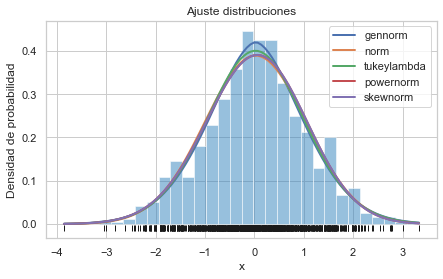



  distribucion  log_likelihood          aic          bic  n_parametros  \
0      gennorm    -1441.728343  2889.456687  2904.179953             3   
1         norm    -1443.431884  2890.863768  2900.679278             2   
2  tukeylambda    -1442.801574  2891.603148  2906.326414             3   
3    powernorm    -1442.999316  2891.998633  2906.721898             3   
4     skewnorm    -1443.020089  2892.040178  2906.763444             3   

                                          parametros  
0  {'beta': 1.7415323052278318, 'loc': 0.02609276...  
1  {'loc': 0.022661865347746116, 'scale': 1.02479...  
2  {'lam': 0.10948509524908664, 'loc': 0.02128443...  
3  {'c': 1.415336126243644, 'loc': 0.359209935580...  
4  {'a': -0.7515033851091366, 'loc': 0.5823255730...  

------------------------------------------------------------------


 ******************** Variable: Datos_E ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters

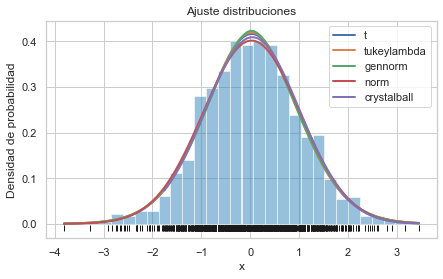



  distribucion  log_likelihood          aic          bic  n_parametros  \
0            t    -1410.318309  2826.636618  2841.359883             3   
1  tukeylambda    -1410.456040  2826.912079  2841.635345             3   
2      gennorm    -1410.829349  2827.658699  2842.381965             3   
3         norm    -1411.934674  2827.869349  2837.684859             2   
4  crystalball    -1409.996736  2827.993472  2847.624493             4   

                                          parametros  
0  {'df': 22.425423988400432, 'loc': 0.0305217150...  
1  {'lam': 0.08979312602091337, 'loc': 0.02913503...  
2  {'beta': 1.813491972417805, 'loc': 0.028689991...  
3  {'loc': 0.030030546292050368, 'scale': 0.99302...  
4  {'beta': 1.9268380971566916, 'm': 1668637.1046...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_1 ******************** 



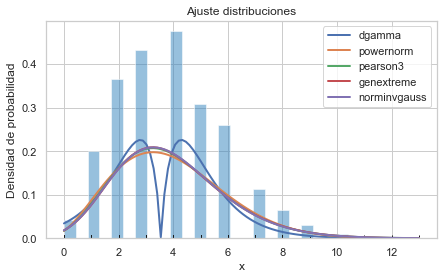



   distribucion  log_likelihood          aic          bic  n_parametros  \
0        dgamma    -2074.956138  4155.912276  4170.635542             3   
1     powernorm    -2083.446632  4172.893265  4187.616530             3   
2      pearson3    -2084.477275  4174.954550  4189.677815             3   
3    genextreme    -2085.978581  4177.957161  4192.680427             3   
4  norminvgauss    -2085.448641  4178.897282  4198.528303             4   

                                          parametros  
0  {'a': 1.8661226241699231, 'loc': 3.54695010438...  
1  {'c': 0.025723273106191352, 'loc': 0.439011575...  
2  {'skew': 0.6410908070647742, 'loc': 3.89598043...  
3  {'c': 0.10923410534526826, 'loc': 3.0464369999...  
4  {'a': 73.34846640431641, 'b': 70.6341436656075...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_3 ******************** 



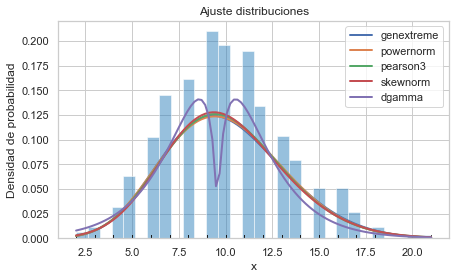



  distribucion  log_likelihood          aic          bic  n_parametros  \
0   genextreme    -2573.493386  5152.986772  5167.710038             3   
1    powernorm    -2573.895936  5153.791872  5168.515138             3   
2     pearson3    -2574.222428  5154.444857  5169.168123             3   
3     skewnorm    -2574.463627  5154.927253  5169.650519             3   
4       dgamma    -2574.900442  5155.800884  5170.524150             3   

                                          parametros  
0  {'c': 0.18619123974091045, 'loc': 8.7193267373...  
1  {'c': 0.1914503003560182, 'loc': 6.33145328554...  
2  {'skew': 0.33930080303021415, 'loc': 9.9830574...  
3  {'a': 1.6320982438351068, 'loc': 7.00311303398...  
4  {'a': 1.6097246082085865, 'loc': 9.56206727536...  

------------------------------------------------------------------


 ******************** Variable: Datos_F ******************** 



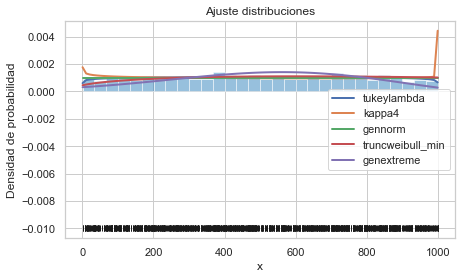



       distribucion  log_likelihood           aic           bic  n_parametros  \
0       tukeylambda    -6904.789830  13815.579661  13830.302927             3   
1            kappa4    -6904.007427  13816.014854  13835.645875             4   
2           gennorm    -6905.753506  13817.507012  13832.230278             3   
3  truncweibull_min    -6920.920002  13851.840003  13876.378780             5   
4        genextreme    -7025.636290  14057.272581  14071.995846             3   

                                          parametros  
0  {'lam': 0.8855693055779876, 'loc': 500.2135581...  
1  {'h': 1.0943412679306672, 'k': 1.0462691417272...  
2  {'beta': 66820028.984968394, 'loc': 499.999989...  
3  {'c': 1.3836505662688365, 'a': 0.0013629473429...  
4  {'c': 0.42224650428234556, 'loc': 419.32690098...  

------------------------------------------------------------------


 ******************** Variable: Datos_G ******************** 



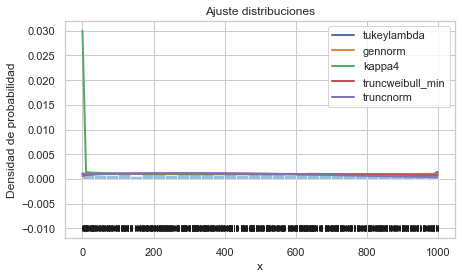



       distribucion  log_likelihood           aic           bic  n_parametros  \
0       tukeylambda    -6906.501235  13819.002469  13833.725735             3   
1           gennorm    -6906.754962  13819.509925  13834.233191             3   
2            kappa4    -6907.445747  13822.891495  13842.522516             4   
3  truncweibull_min    -6908.346592  13826.693183  13851.231959             5   
4         truncnorm    -7022.566525  14053.133050  14072.764071             4   

                                          parametros  
0  {'lam': 1.0315261581245263, 'loc': 499.4971424...  
1  {'beta': 73783334.82779665, 'loc': 499.4999995...  
2  {'h': 1.1049590641475988, 'k': 0.9898133182156...  
3  {'c': 1.1482419816432965, 'a': 0.0009375580588...  
4  {'a': -0.6691330199752074, 'b': 95929.07318948...  

------------------------------------------------------------------



In [166]:
ejemplo.comparar_distribuciones_caunti_cont()

## Quitar outlaiers

# PLOTS

In [167]:
#ejemplo.todos_plots()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

-------------- Graficas de bigotes cualitativas-------------------


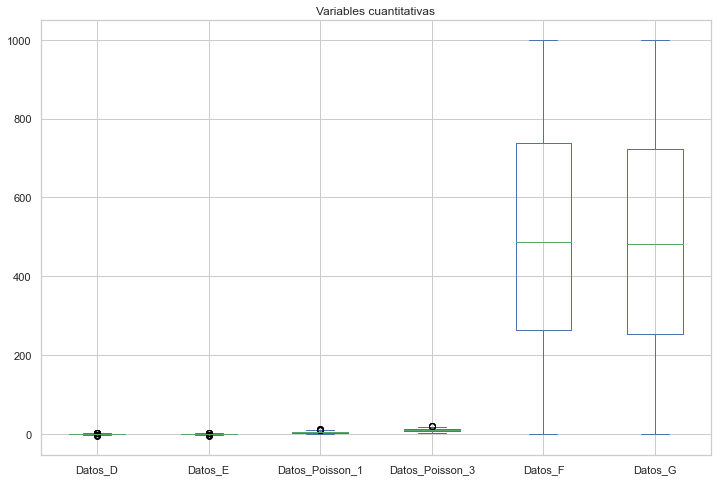

-------------- Graficas de bigotes por dicotomicas-------------------


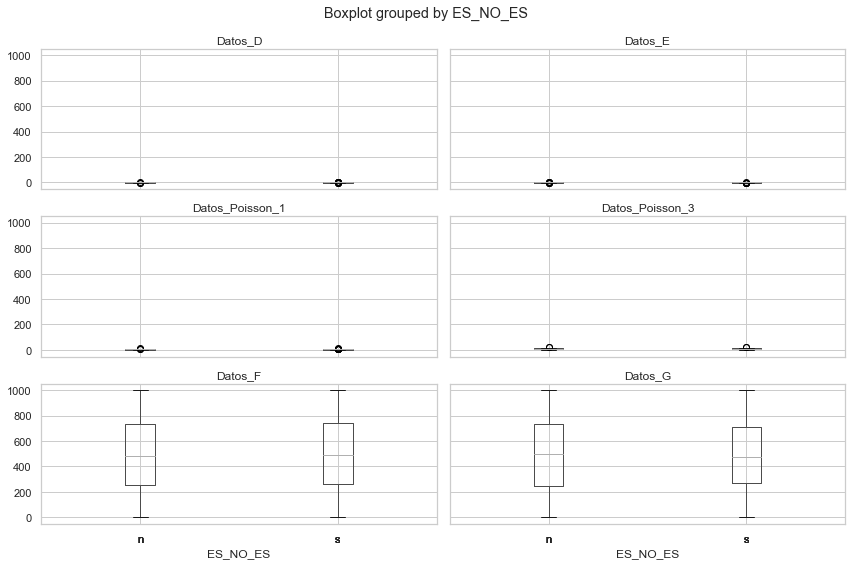

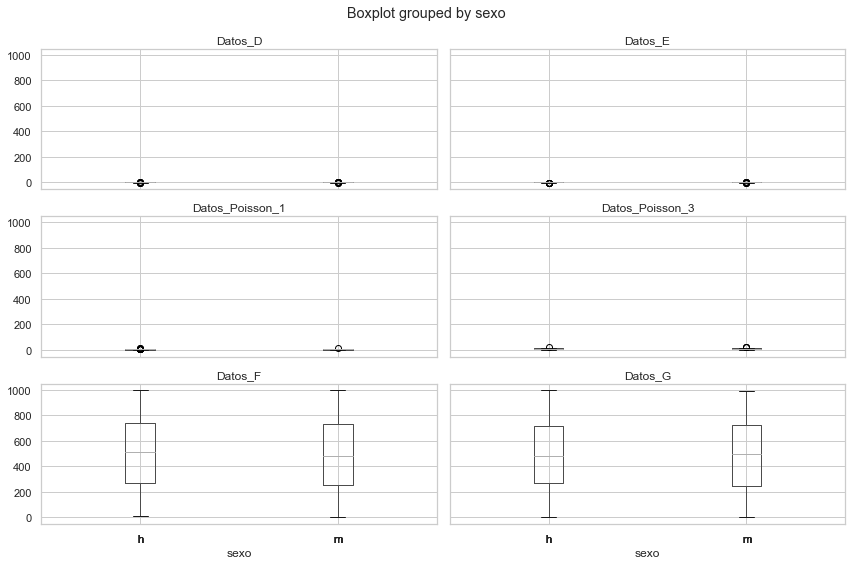

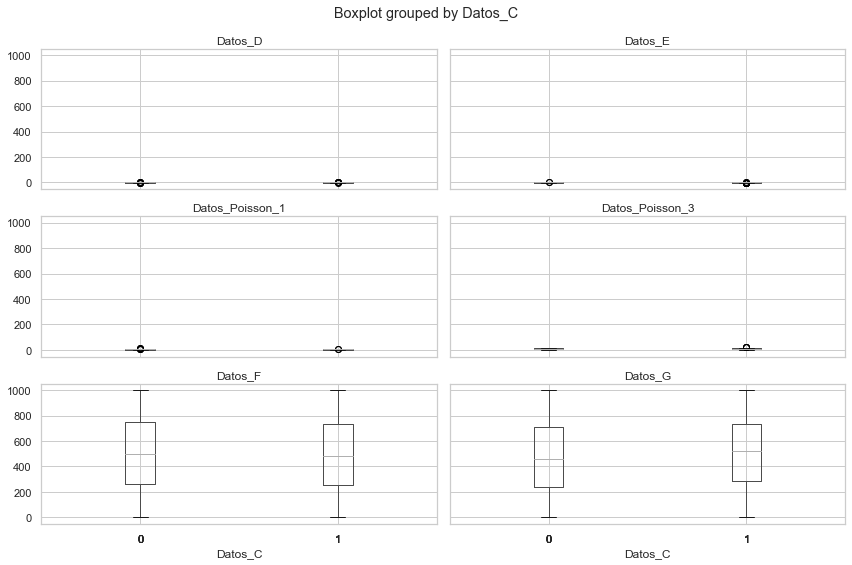



----------------------------------------------------------------------------------------------------

-------------- Graficas de bigotes por categoricas-------------------


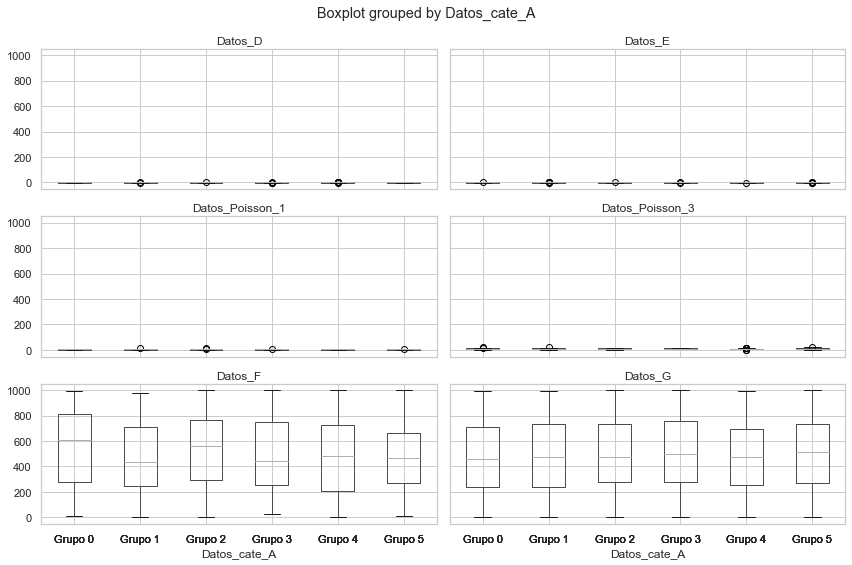

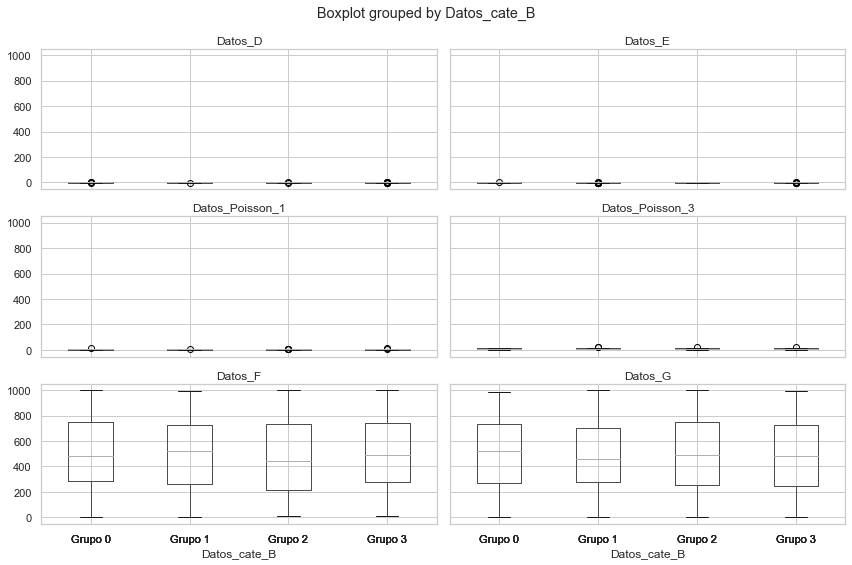



----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [168]:
ejemplo.plot_bigotes()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

----------------------------------------------------------------------------------------------------

-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------



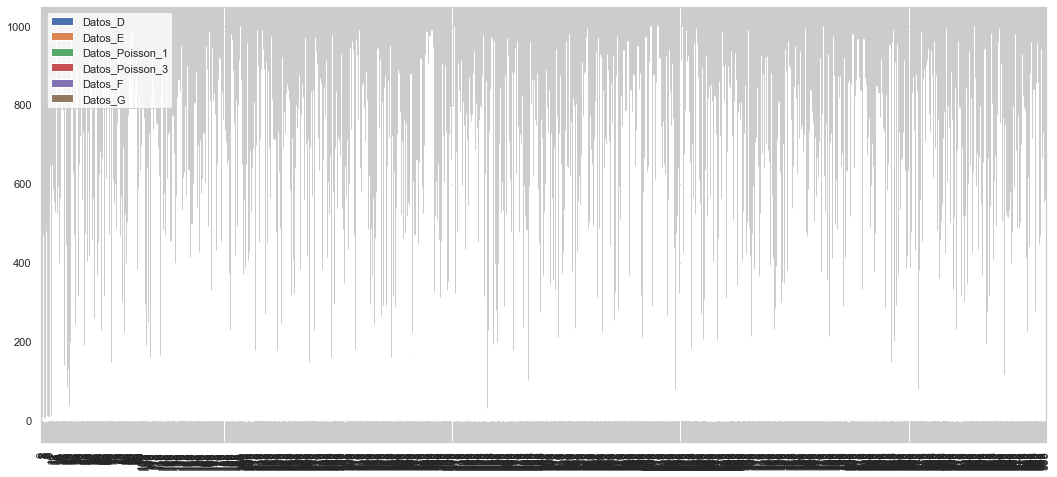

-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------


.............. GRAFICA DE BARRAS  DE Datos_D ............



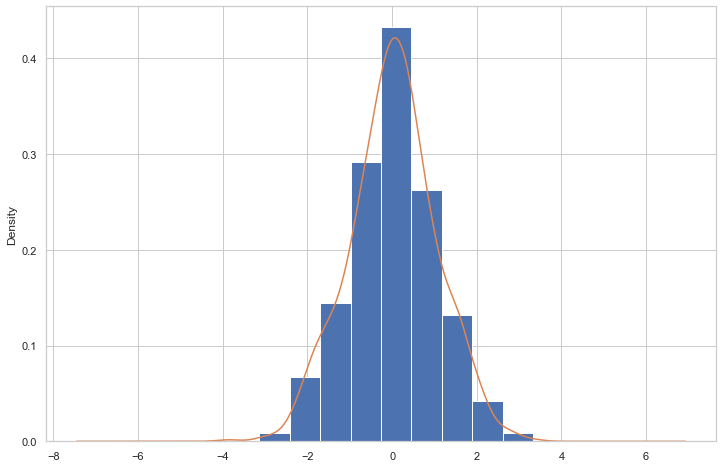


.............. GRAFICA DE BARRAS  DE Datos_E ............



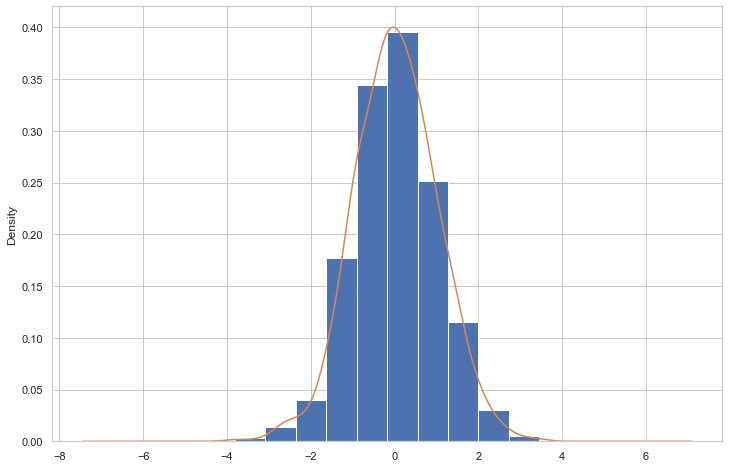


.............. GRAFICA DE BARRAS  DE Datos_Poisson_1 ............



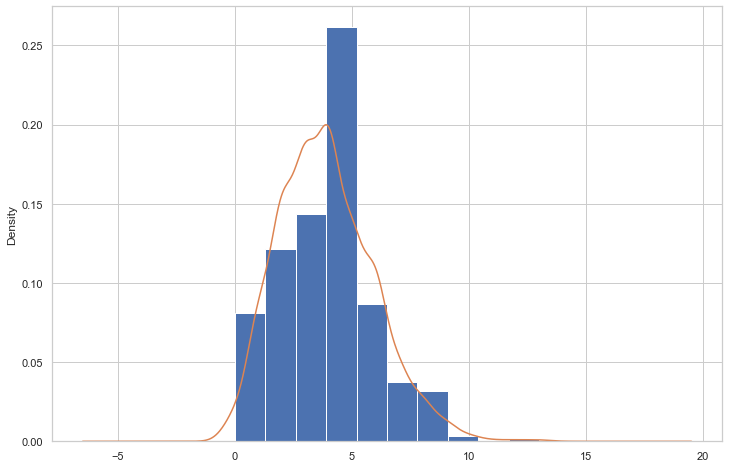


.............. GRAFICA DE BARRAS  DE Datos_Poisson_3 ............



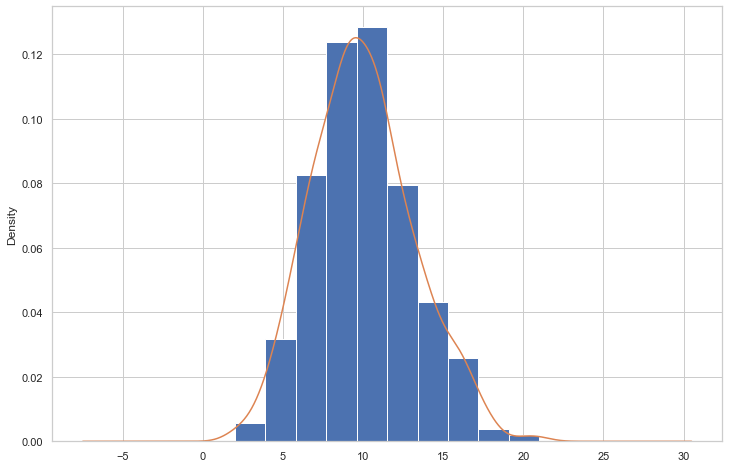


.............. GRAFICA DE BARRAS  DE Datos_F ............



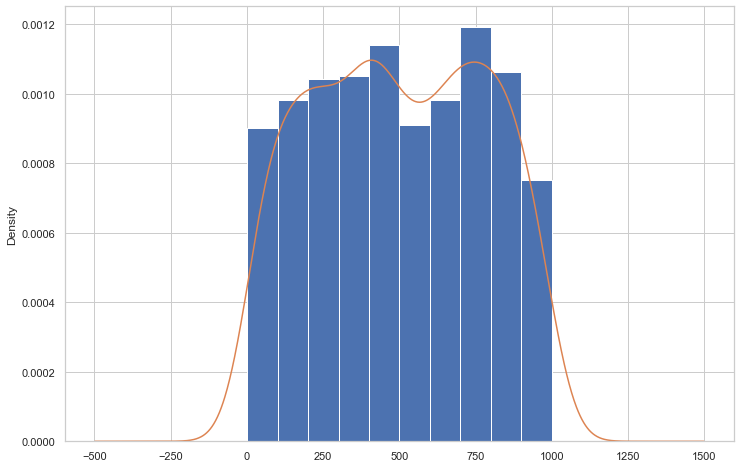


.............. GRAFICA DE BARRAS  DE Datos_G ............



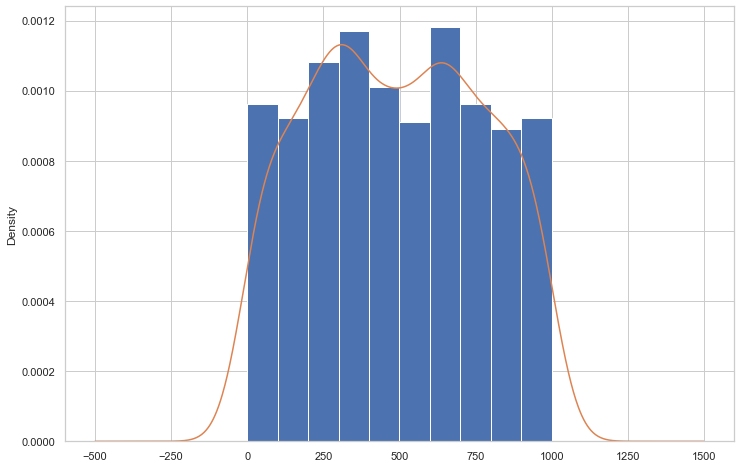

----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [169]:
ejemplo.plot_barras()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

----------------------------------------------------------------------------------------------------

-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------



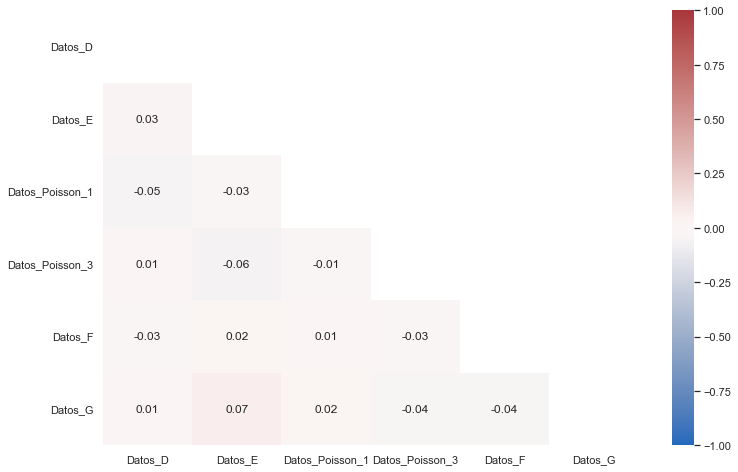

----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [170]:
ejemplo.plot_corr()

--------------  GRAFICA DE VIOLINES  -------------------



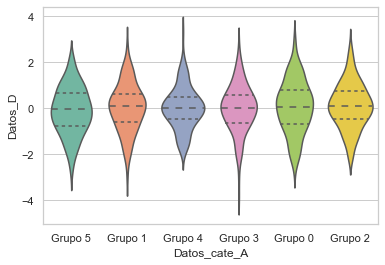

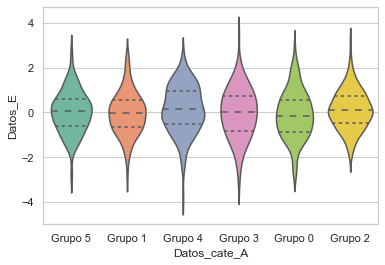

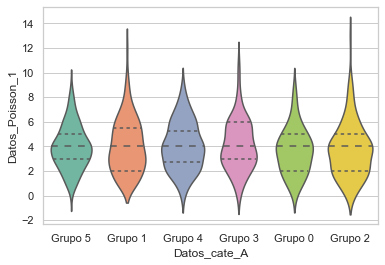

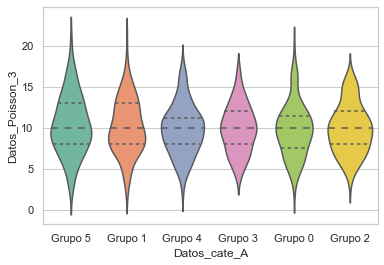

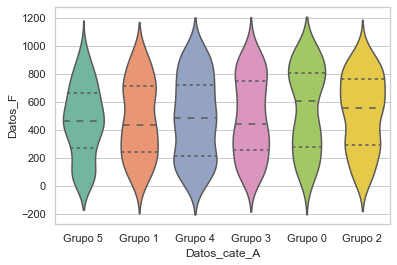

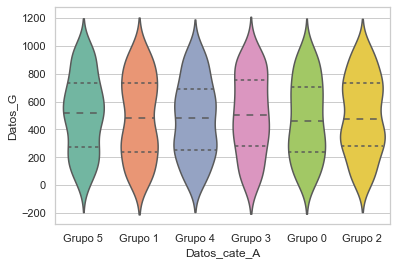

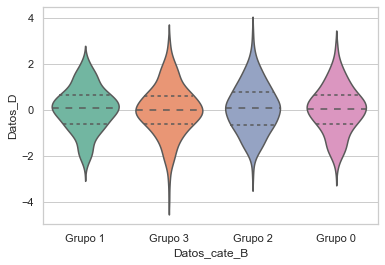

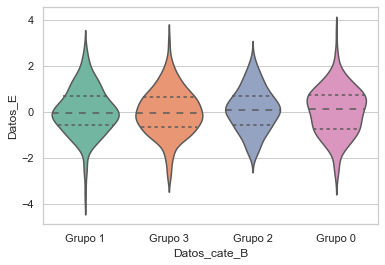

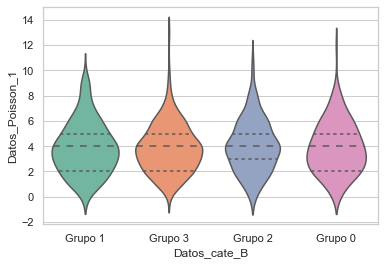

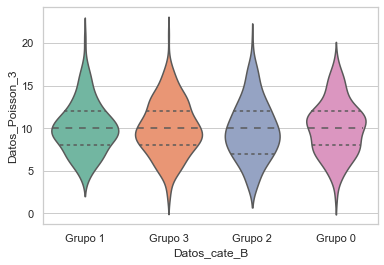

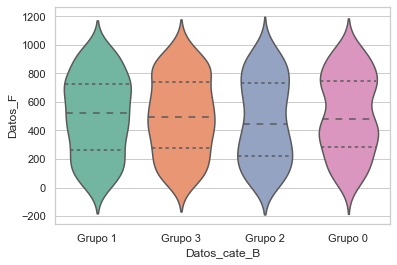

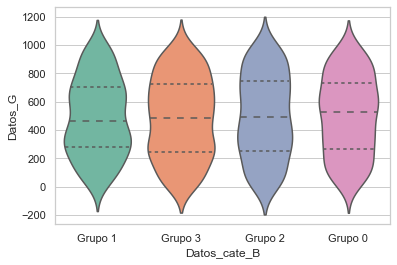



/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////



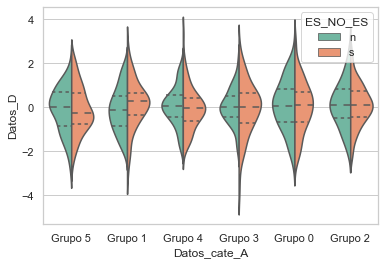

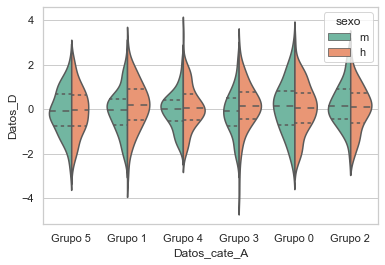

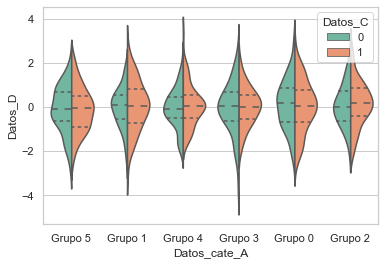

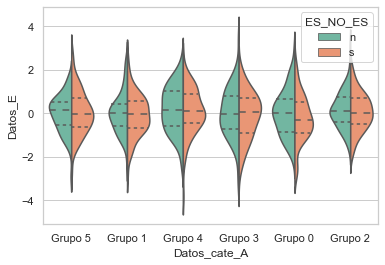

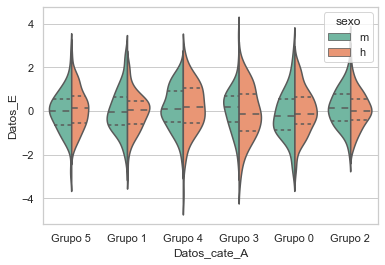

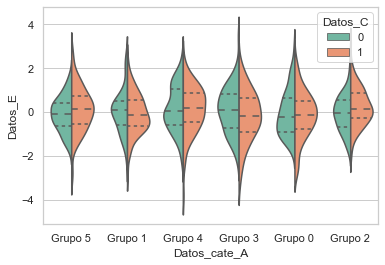

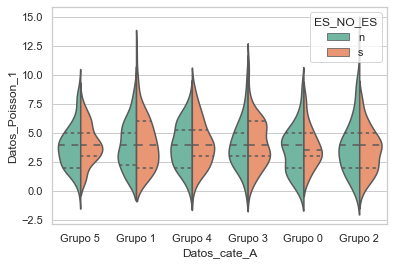

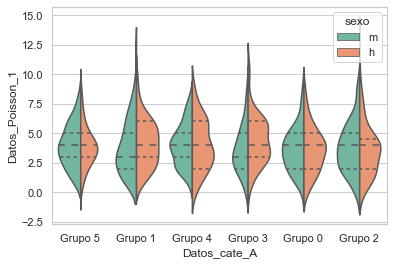

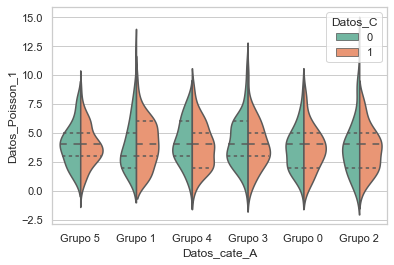

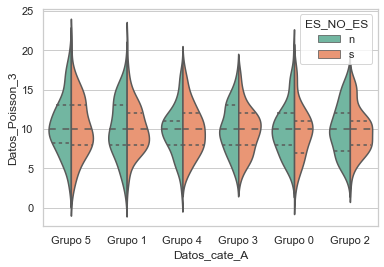

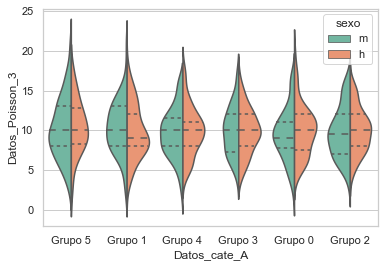

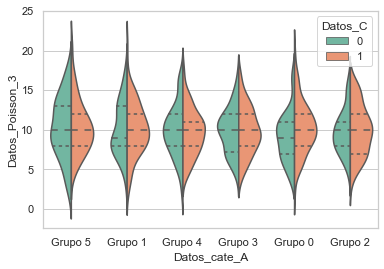

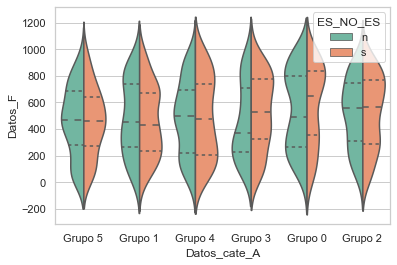

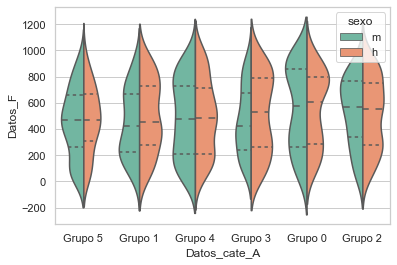

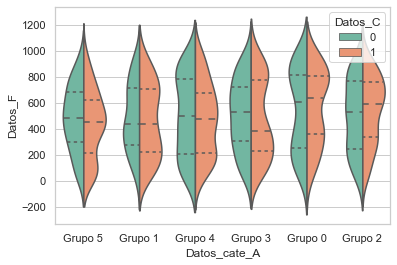

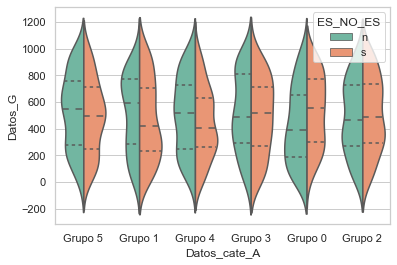

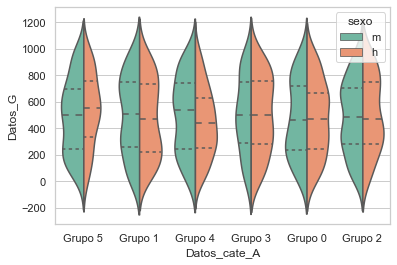

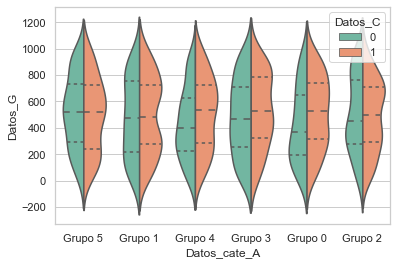

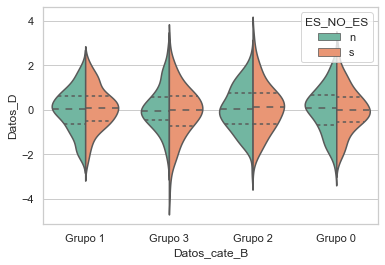

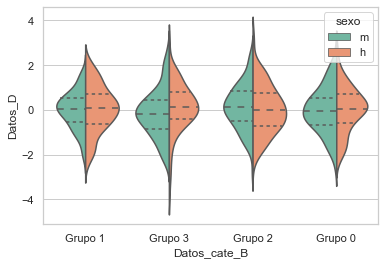

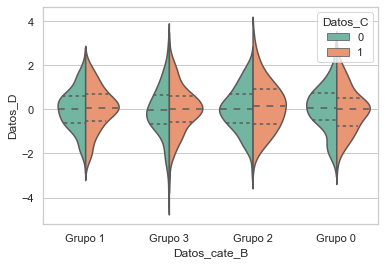

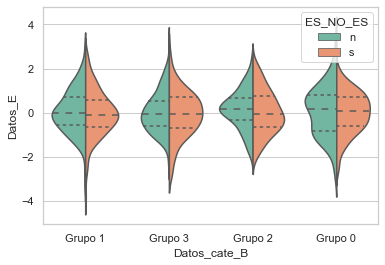

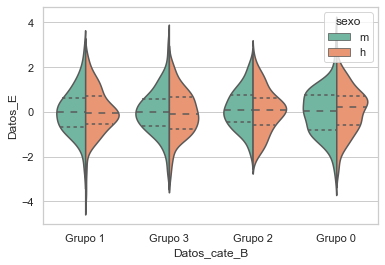

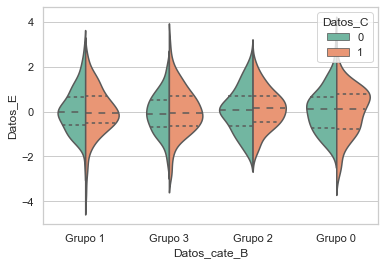

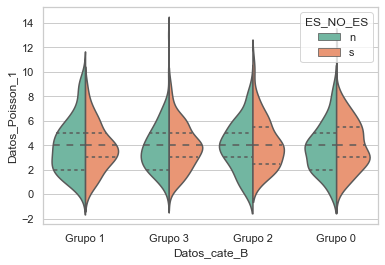

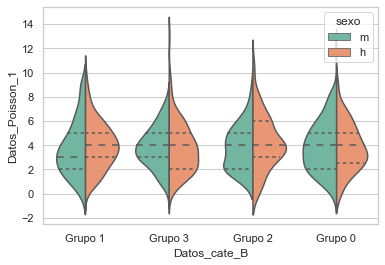

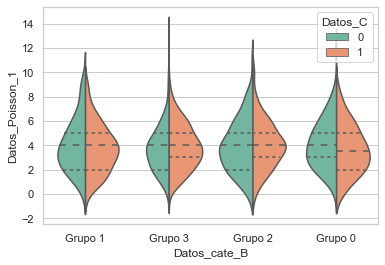

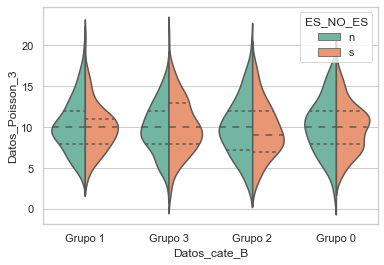

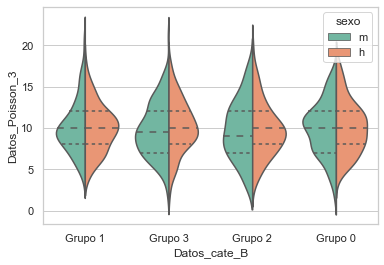

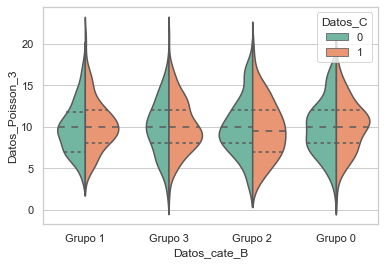

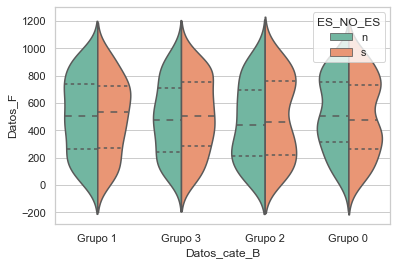

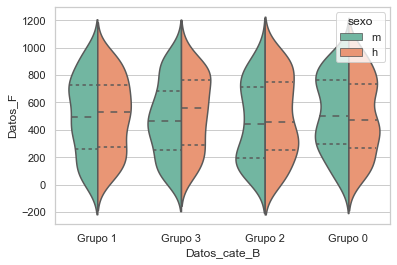

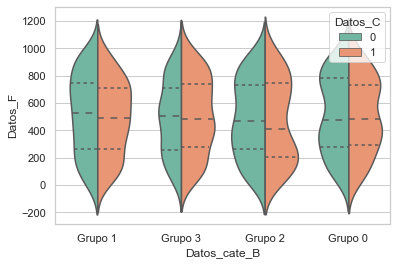

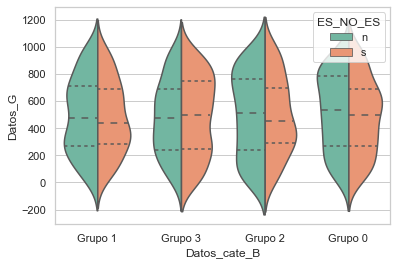

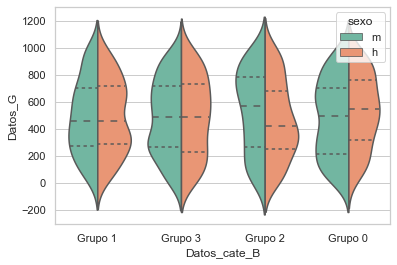

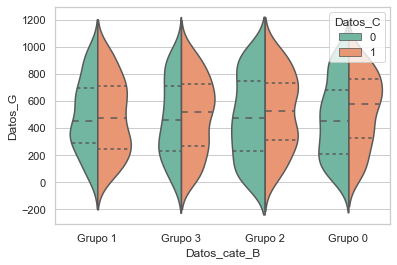

In [171]:
ejemplo.violines()

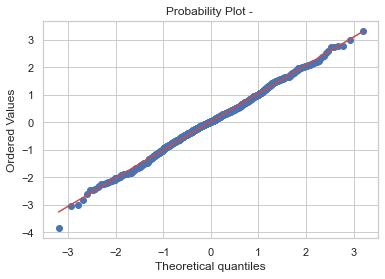

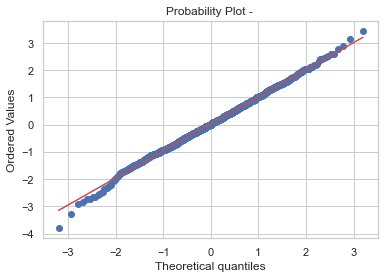

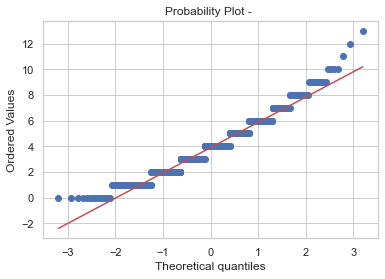

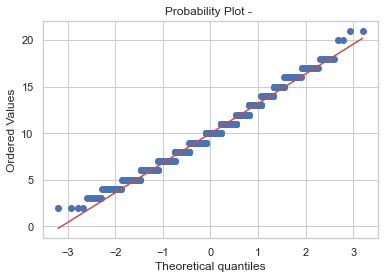

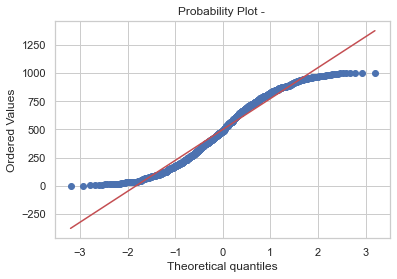

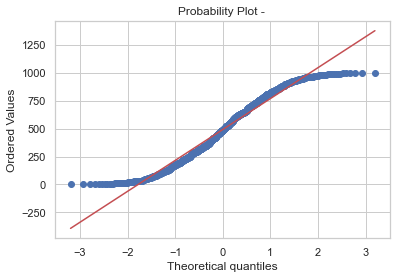

In [172]:
ejemplo.plot_normailidad()

# TEST ESTADISTICOS

## Chi2

In [173]:
ejemplo.Chi()


-------------- Chi2 entre ES_NO_ES y sexo ----------------
p: 0.6619133114101157 


-------------- Chi2 entre ES_NO_ES y Datos_C ----------------
p: 0.3403799698416468 


-------------- Chi2 entre sexo y Datos_C ----------------
p: 0.06224934600407592 



## T_student

# Wilconxon

## Anova

In [174]:
ejemplo.anova()


----------- ANOVA Categoria Datos_cate_A y variable continua Datos_D ----------

                   sum_sq     df         F    PR(>F)
Datos_cate_A     4.968438    5.0  0.944977  0.450896
Residual      1045.237947  994.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_E ----------

                  sum_sq     df         F    PR(>F)
Datos_cate_A    6.967388    5.0  1.414651  0.216302
Residual      979.122545  994.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_Poisson_1 ----------

                   sum_sq     df         F    PR(>F)
Datos_cate_A    30.285359    5.0  1.510129  0.183892
Residual      3986.898641  994.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_Poisson_3 ----------

                    sum_sq     df         F    PR(>F)
Datos_cate_A     42.547622    5.0  0.828112  0.529697
Residual      10214.163378  994.0       NaN       NaN

----------- ANOVA C

In [175]:
# # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
# fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
# print(fvalue, pvalue)
# # 17.492810457516338 2.639241146210922e-05

# # get ANOVA table as R like output
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # Ordinary Least Squares (OLS) model
# model = ols('value ~ C(treatments)', data=df_melt).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table
# # output (ANOVA F and p value)
#                 sum_sq    df         F    PR(>F)
# C(treatments)  3010.95   3.0  17.49281  0.000026
# Residual        918.00  16.0       NaN       NaN

# # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
# from bioinfokit.analys import stat
# res = stat()
# res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary
# # output (ANOVA F and p value)
#                  df   sum_sq   mean_sq         F    PR(>F)
# C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
# Residual       16.0   918.00    57.375       NaN       NaN

# # note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# # (typ parameter) will produce similar results.

In [176]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
#  
# for x in categorical_col:
#     model = ols('cnt' + '~' + x, data = BIKE).fit() #Oridnary least square method
#     result_anova = sm.stats.anova_lm(model) # ANOVA Test
#     print(result_anova)

In [177]:
# aux=list(ejemplo.cuanti.columns)
# aux_DF=ejemplo.df_inputado
# for i in aux:
#     z = np.abs(stats.zscore(aux_DF[i]))
#     print(f"+++++++++{i}++++++++++++")
#     print(z)


In [178]:
x=df_prueba["Datos_Poisson_1"]
mean = x.mean()
var = x.var()
likelihoods = {}  # we'll use it later
log_likelihoods = {}

p = 1 - mean / var  # : check for zero variance and limit p by [0, 1]
r = (1-p) * mean / p


likelihoods['nbinom'] = x.map(lambda val: stats.nbinom.pmf(val, r, p)).prod()
log_likelihoods['nbinom'] = x.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

lambda_ = mean
likelihoods['poisson'] = x.map(lambda val:  stats.poisson.pmf(val, lambda_)).prod()
log_likelihoods['poisson'] = x.map(lambda val: stats.poisson.logpmf(val, r, p)).sum()

# mean = 1 / p  # this form fits the scipy definition
p = 1 / mean

likelihoods['geometric'] = x.map(lambda val:  stats.geom.pmf(val, p)).prod()
log_likelihoods['geometric'] = x.map(lambda val: stats.geom.logpmf(val, r, p)).sum()

best_fit = max(likelihoods, key=lambda x: likelihoods[x])
print(likelihoods)
print("Best fit:", best_fit)
print("Likelihood:", likelihoods[best_fit])

print("\n")

best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
print("Best fit:", best_fit)
print("log_Likelihood:", log_likelihoods[best_fit])

{'nbinom': 0.0, 'poisson': 0.0, 'geometric': 0.0}
Best fit: nbinom
Likelihood: 0.0


Best fit: geometric
log_Likelihood: 0.0
